<div style="font-size: 20px">
  Group:
  <br>
  Homework H 
  <br>
  Created by: Muazzam Bin Aqeel---(Matrikel-Nr. 3139776) & Wesley dos santos Barisch---(Matrikel-Nr. 3140227)
</div>


# Segmentation - Mini Project

## Introduction

Now it´s your turn to put it all together and train a segmentation model on a new dataset. The dataset is called "Freiburg Forest Dataset" and it contains images of forest scenes (See dataset README). The data set is located under `/data/Freiburg_Forest_Dataset`. The goal is to segment the classes "Void", "Road", "Grass", "Vegetation", "Tree", "Sky" and "Obstacle". The special thing about that dataset is that it contains multispectral and multimodal images (RGB, NIR, Depth Map etc.). <br>
Feel free to follow the CRISP-DM framework to structure your work. <br>
Overall you should at least cover the following topics:
- **Data Understanding and Data Preparation:** <br>
Build a PyToch Dataset to read in the data and analyze the dataset by plotting some samples and the class distribution. You can start by using only the RGB images and the corresponding masks.
- **Training:** <br>
Use the simplified U-Net from the lecture as a starting point and train the model on the dataset
- **Evaluation:** <br>
Evaluate the model on the test set using the accuracy and mean IoU and visualize some predictions

From here you can go further and try different things:
- **Use more modalities:** <br>
Change the dataset to use different modalities and train/evaluate the model on them (e.g. the Depth Maps)
- **Use more advanced architectures:** <br>
Try more advanced architectures by using the [Pytorch Segmentation Models Package](https://github.com/qubvel/segmentation_models.pytorch)

Use this notebook as a starting point and make sure to explain your steps and discuss your results. The goal is not to get the best possible results but to create a well structured data science story. But of course, if you get good results, that´s great! <br>
Feel free to reuse code from the lecture notebooks if you find it useful. <br>

In [20]:
# import libraries
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import os
import time

print(torch.__version__)
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
use_cuda = cuda_available

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    m_params = params / 1e6
    print(f"Model has {m_params:.2f}M parameters")


2.1.0+cu118
cuda available: True


Unique values in mask: [  0  51  60 102 120 170 255]


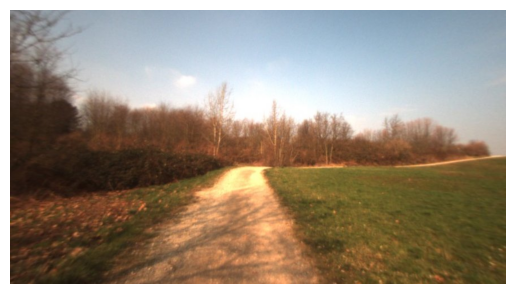

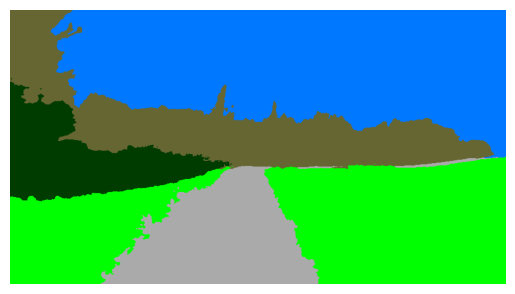

In [21]:

image = Image.open("data/Freiburg_Forest_Dataset/train/rgb/b1-99445.jpg")
mask = Image.open("data/Freiburg_Forest_Dataset/train/GT_color/b1-99445.png")
mask_np = np.array(mask)
print(f"Unique values in mask: {np.unique(mask_np)}")
plt.imshow(image)
plt.axis("off")
plt.show()
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.show()


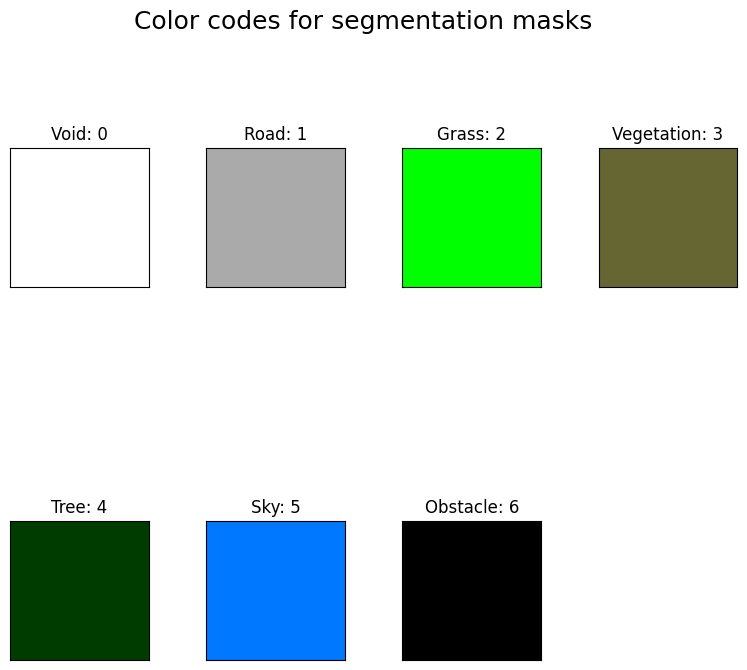

In [22]:

freiburg_color_codes = {
    "Void": (-1, -1, -1),
    "Road": (170, 170, 170),
    "Grass": (0, 255, 0),
    "Vegetation": (102, 102, 51),
    "Tree": (0, 60, 0),
    "Sky": (0, 120, 255),
    "Obstacle": (0, 0, 0)
}

freiburg_class_indices = {
    0: "Void",
    1: "Road",
    2: "Grass",
    3: "Vegetation",
    4: "Tree",
    5: "Sky",
    6: "Obstacle"
}
freiburg_class_indices_rev = {k : i for i, k in enumerate(freiburg_color_codes.keys())}

def colorcode_segmentation(np_mask, color_codes, class_indices):
    """colorizes the segmentation mask using the carla color codes"""
    height, width = np_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=int)
    
    for i in np.unique(np_mask):
        rgb_mask[np_mask == i] = color_codes[class_indices[i]]
    return rgb_mask
    

fig, axs = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(8, 8)
fig.suptitle('Color codes for segmentation masks', size=18)
fig.tight_layout()

index = 0
for idx, label in freiburg_class_indices.items():
    img = np.zeros([50, 50, 3], dtype=np.uint8)
    color = np.asarray(freiburg_color_codes[label])
    img[:, :, :] = color
    i = index // 4
    j = index % 4
    axs[i, j].set_title(f'{label}: {idx}')
    axs[i, j].imshow(Image.fromarray(img))
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    index += 1
for i in range(index, 8):
    fig.delaxes(axs.flatten()[i])

plt.show()


## Data Understanding and Preparation

For this notebook we will be using the Freiburg_Forest_Dataset, as per the defined requirements.

In [23]:
class FreiburgDataset(Dataset):
    def __init__(self, path, image_transform=None, label_transform=None, is_train=True, limit=None):
        self.path = path
        self.limit = limit
        self.is_train = is_train
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.files = self._get_files()
        print(f"Found {len(self.files)} files.")  # Debugging statement
        self.data = []
        for image, mask in tqdm(self.files):
            self.data.append(self._process(image, mask))

    def _get_files(self):
        # Get all the image files in the directory
        folder = 'train' if self.is_train else 'test'
        image_path = os.path.join(self.path, folder, 'rgb')
        data_files = []
        for root, _, files in os.walk(image_path):
            for i, file in enumerate(files):
                if file.endswith('.jpg') and '.ipynb_checkpoints' not in root:
                    image_file = os.path.join(root, file)
                    segmentation_mask = image_file.replace('rgb', 'GT_color')
                    segmentation_mask = segmentation_mask.replace('.jpg', '.png')
                    data_files.append((image_file, segmentation_mask))
                    if self.limit and i >= self.limit:
                        break
        return data_files

    def _process(self, image, mask):
        image = Image.open(image)
        mask = Image.open(mask)
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            mask = self.label_transform(mask)
        return image, mask

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.data[idx]


In [24]:
SHAPE = (128, 128)
# image transform to transform the image to tensor, resize and normalize
image_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for transforming the mask to a tensor with the class labels we will create a custom transform
class MaskToTensor(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mask_values = np.array([0, 1, 2, 3, 4, 5, 6])

    def __call__(self, mask):
        seg = np.array(mask)
        if seg.ndim == 3 and seg.shape[2] == 3:
            single_channel_mask = np.zeros((seg.shape[0], seg.shape[1]), dtype=np.int64)
            for color, class_idx in freiburg_color_codes.items():
                single_channel_mask[(seg == class_idx).all(axis=2)] = freiburg_class_indices_rev[color]
            seg = single_channel_mask
        else:
            print("Error in the shape of the segmentation mask!")

        one_hot_mask = torch.zeros((seg.shape[0], seg.shape[1]), dtype=torch.long)

        for i, value in enumerate(self.mask_values):
            binary_mask = seg == value
            one_hot_mask[binary_mask] = i
        
        return one_hot_mask

# label transform to transform the label to tensor and resize
label_transform = transforms.Compose([
    transforms.Resize(SHAPE, interpolation=InterpolationMode.NEAREST_EXACT),
    MaskToTensor(6)
])

# test our transformation
image = Image.open("data/Freiburg_Forest_Dataset/train/rgb/b1-99445.jpg")
mask = Image.open("data/Freiburg_Forest_Dataset/train/GT_color/b1-99445.png")

mask = label_transform(mask)
print(f"Mask shape: {mask.shape}, unique values: {torch.unique(mask)}, dtype: {mask.dtype}")
image = image_transform(image)
print(f"Image shape: {image.shape}, min: {image.min()}, max: {image.max()}, mean: {image.mean()}, std: {image.std()}, dtype: {image.dtype}")



Mask shape: torch.Size([128, 128]), unique values: tensor([1, 2, 3, 4, 5]), dtype: torch.int64
Image shape: torch.Size([3, 128, 128]), min: -1.7731091976165771, max: 2.640000104904175, mean: 0.20317025482654572, std: 1.2000634670257568, dtype: torch.float32


In [25]:
# Example usage
BATCH_SIZE = 32
# create the dataset
train_dataset = FreiburgDataset('data/Freiburg_Forest_Dataset', image_transform, label_transform, is_train=True, limit=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = FreiburgDataset('data/Freiburg_Forest_Dataset', image_transform, label_transform, is_train=False, limit=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Found 230 files.


100%|██████████| 230/230 [00:02<00:00, 84.57it/s]


Found 136 files.


100%|██████████| 136/136 [00:01<00:00, 87.09it/s]


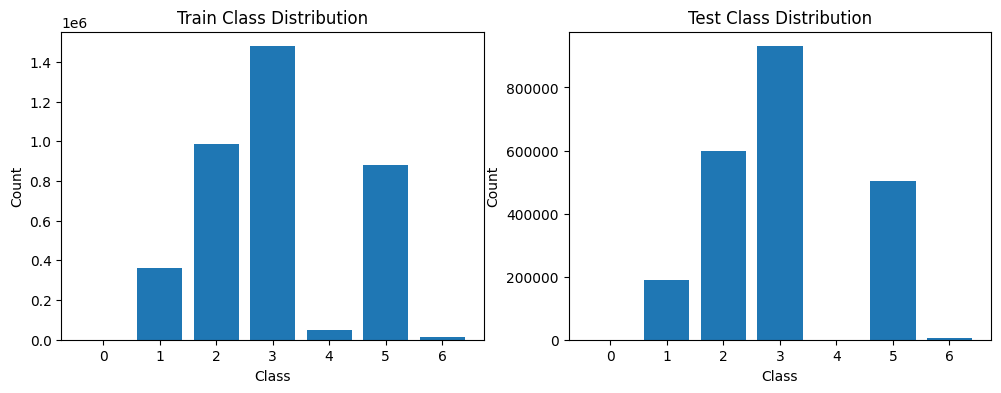

In [26]:
# analyze the per pixel class distribution
def calculate_class_distribution(dataset):
    # Your solution goes here: Implement this function It should return a list of 16 elements where each element is the number of pixels of that class in the dataset
    class_counts = [0] * 7
    
    for image, label in dataset:
        flattened_label = label.flatten()
        for class_id in range(7):
            class_counts[class_id] += (flattened_label == class_id).sum()
    return class_counts

train_class_distribution = calculate_class_distribution(train_dataset)
test_class_distribution = calculate_class_distribution(test_dataset)


# plot the class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(7), train_class_distribution)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
plt.bar(range(7), test_class_distribution)
plt.title("Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

<b>Interpretation</b>: 
<br>
The training and test datasets display notable class imbalance. For example, Class 3 contains the most pixels in both datasets, whereas Class 4 has the least. This imbalance could lead to the model underperforming on classes with fewer examples. The class distribution in the training set closely reflects that in the test set, indicating that the data splits were appropriately managed.

Now we will take the helper functions from the introduction notebook and test the model.

In [27]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)
            
def show_img(image):
    min_img = image.min()
    max_img = image.max()
    showimg = ((image-min_img)/(max_img-min_img)).permute(1, 2, 0)
    return showimg
       
def visualize_segmentation(model, test_loader, device):
    # visualize some images
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.permute(0, 2, 3, 1)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=3)
    output = output.cpu().numpy()
    labels = labels.cpu().numpy()

    # Increase the plot size
    plt.figure(figsize=(12, 6))

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(show_img(images[i]).cpu().numpy())
        plt.title('Input Image')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 6)
        plt.imshow(colorcode_segmentation(output[i],freiburg_color_codes, freiburg_class_indices))
        plt.title('Predicted Mask')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 11)
        plt.imshow(colorcode_segmentation(labels[i],freiburg_color_codes, freiburg_class_indices))
        plt.title('Ground Truth')
        plt.axis('off')  # Remove the axis
    plt.show()


## Modelling
<br>
Using the simplified U-Net architecture for image segmentation
<br>
In this notebook, you shall use the [Upsample (https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) operation to upsample the feature maps followed by a [2D Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer. <br>

In [28]:
class DownLayer(nn.Module):
    """
    Abstraction of a down layer in a CNN. A down layer consists of a convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(DownLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x
    
class UpLayerTranspose(nn.Module):
    """
    Abstraction of a up layer in a CNN. A up layer consists of a transposed convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(UpLayerTranspose, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, output_padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x
    
    
class UpLayerInterpolate(nn.Module):
    """
    Abstraction of a up layer in a CNN. A up layer consists of a nearest neighbor interpolation layer followed by a convolutional layer and ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(UpLayerInterpolate, self).__init__()
        # Initialize the upsample layer and the convolutional layer
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)


        
    def forward(self, x):
        # Implement the forward pass which upsamples the input tensor x and applies the convolutional layer and ReLU activation function
        x = self.up(x)
        x = self.conv(x)
        x = F.relu(x)
        return x
    
# test the up layer
up = UpLayerInterpolate(1, 1)
data = torch.randn(1, 1, 16, 16)
output = up(data)
print(f"Output shape: {output.shape}") # If the output shape is torch.Size([1, 1, 32, 32]) then the implementation is correct

Output shape: torch.Size([1, 1, 32, 32])


In [29]:
class UnetCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 64, 128], output_dim=7):
        super(UnetCNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        # Encoder layers
        self.encoder_hidden_layers = nn.ModuleList()
        in_dim  = input_dim
        for i in range(0, len(hidden_dims)):
            self.encoder_hidden_layers.append(DownLayer(in_dim, hidden_dims[i]))
            in_dim = hidden_dims[i]
        
        # Decoder layers
        self.decoder_hidden_layers = nn.ModuleList()
        in_dim = hidden_dims[-1]
        for i in range(len(hidden_dims)-1, -1, -1):
            self.decoder_hidden_layers.append(UpLayerInterpolate(in_dim * 2, hidden_dims[i - 1]))
            in_dim = hidden_dims[i - 1]
        self.output_layer = nn.Conv2d(in_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        # list to store the output of the encoder layers
        output_encoder = []
        # forward pass trough the encoder
        for hidden_layer in self.encoder_hidden_layers:
            x = hidden_layer(x)
            x = F.relu(x)
            # store the output of the encoder layers
            output_encoder.append(x)

        # forward pass trough the decoder
        for i, hidden_layer in enumerate(self.decoder_hidden_layers):
            # concatenate the output of the encoder layers
            x = torch.cat([x, output_encoder[-i - 1]], dim=1)
            x = hidden_layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        return x
    
# test if our model works for segmentation by keeping the original input dimensions
model = UnetCNN()
test_image = torch.rand(1, 3, 128, 128)
output = model(test_image)
print(f"Input shape: {test_image.shape}, output shape: {output.shape}")
assert test_image.shape[2:] == output.shape[2:], "Input and output dimensions should be the same"


Input shape: torch.Size([1, 3, 128, 128]), output shape: torch.Size([1, 7, 128, 128])


## Training
Next we initialize the network and define the loss function and optimizer

In [30]:
# create the network
model = UnetCNN(hidden_dims=[16, 32, 64, 128])
count_parameters(model)
# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# create the loss function
criterion = nn.CrossEntropyLoss()
# set the device
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

Model has 0.34M parameters


UnetCNN(
  (encoder_hidden_layers): ModuleList(
    (0): DownLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): DownLayer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): DownLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder_hidden_layers): ModuleList(
    (0): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1,

In [31]:
EPOCHS = 20
train_losses = []
test_losses = []
start_time = time.time()
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    test_loss = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    pbar.set_description(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
end_time = time.time()
print(f"Training time in minutes: {(end_time - start_time) / 60:.2f} on {device} for {EPOCHS} epochs")

Epoch 20, Train Loss: 0.3004, Test Loss: 0.2906: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

Training time in minutes: 0.07 on cuda for 20 epochs


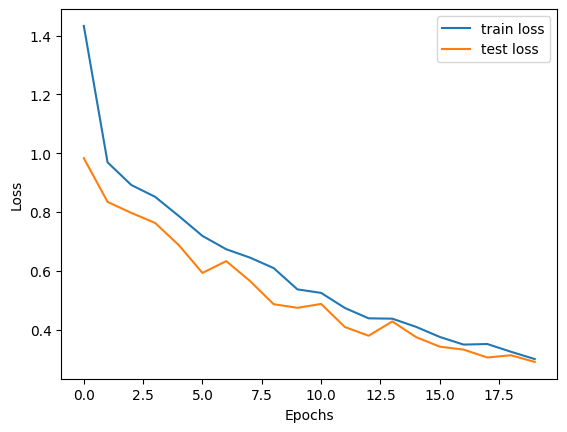

In [32]:
# plot the train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Initially, both training and test losses are high, which is normal since the model starts with random weights and hasn't learned yet.

As training progresses, both losses steadily decrease. This indicates that the model is improving its predictions by adjusting its weights based on the data it sees during training.

Throughout the training process, the training loss is slightly lower than the test loss, which suggests that the model is generalizing well to unseen data and is not overfitting.

Towards the end, around 15 epochs, both losses begin to level off, indicating that the model has almost converged and further training may not significantly reduce the loss.

## Evaluation

In [33]:
def intersection(prediction, target, relevant_class=1):
    """
    Calculate the intersection between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the intersection for
    """
    # Your solution goes here
    # calculate the intersection
    
    # Convert prediction and target to binary masks for the relevant class
    prediction_class = (prediction == relevant_class).float()
    target_class = (target == relevant_class).float()
    
    # Calculate the intersection
    intersection = (prediction_class * target_class).sum(dim=(1, 2))
    return intersection

def union(prediction, target, relevant_class=1):
    """
    Calculate the union between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the union for
    """
    # Your solution goes here
    # calculate the union
    
    # Convert prediction and target to binary masks for the relevant class
    prediction_class = (prediction == relevant_class).float()
    target_class = (target == relevant_class).float()
    
    # Calculate the union
    union = (prediction_class + target_class).clamp(0, 1).sum(dim=(1, 2))
    return union
 


def iou(prediction, target):
    """
    Calculate the mean intersection over union for the prediction and target
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    # calculate the number of classes
    class_indices = torch.unique(target)
    # initialize the list to store the iou for each class
    iou_per_class = []
    # iterate over each class
    for i in class_indices:
        # calculate the intersection for the class
        inter = intersection(prediction, target, i)
        # calculate the union for the class
        uni = union(prediction, target, i)
        # calculate the iou for the class
        iou = inter / uni
        iou_per_class.append(iou)
    # calculate the mean iou
    return torch.mean(torch.stack(iou_per_class)).item()    
    
# test the implementation 
prediction = torch.tensor([[[1, 2 , 1], [1, 1, 1], [2, 2, 2]]])
target = torch.tensor([[[1, 1, 1], [1, 2, 1], [2, 1, 2]]])
print(f"IOU: {iou(prediction, target)}") # If the IOU is ~0.4857 then the implementation is correct

IOU: 0.485714316368103


In [34]:
def accuracy(output, target):
    """
    Function to calculate the accuracy given the output and target
    Args:
    - output: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    accuracy = torch.sum(output == target) / (output.shape[0] * output.shape[1] * output.shape[2])
    return accuracy.item()
    

def validate(model, test_loader, device):
    model.eval()
    accuracy_list = []
    iou_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            # argmax to get the class index
            output = torch.argmax(output, dim=1)
            accuracy_list.append(accuracy(output, labels))
            iou_list.append(iou(output, labels))
    mean_accuracy = sum(accuracy_list) / len(test_loader)
    mean_iou = sum(iou_list) / len(test_loader)
    return mean_accuracy, mean_iou


m_accuracy, m_iou = validate(model, test_loader, device)
print(f'Accuracy: {m_accuracy}, IoU: {m_iou}')

100%|██████████| 5/5 [00:00<00:00, 98.89it/s]

Accuracy: 0.9002056121826172, IoU: nan


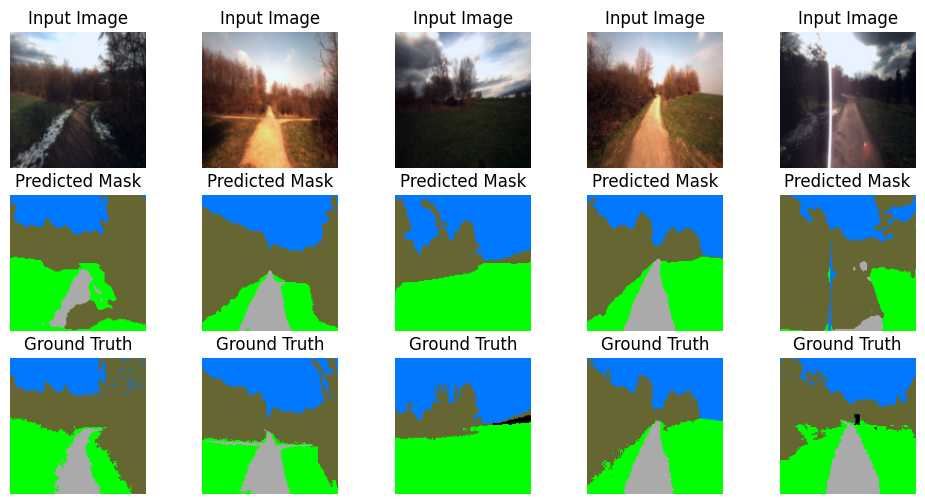

In [35]:
visualize_segmentation(model, test_loader, device)

Iterpretation: The differences from the Ground truth In the first picture do make sense because of the overlapping shadow at the start. Similary, the second picture gets lower quality segmentation on the left due to shadows. The last picture if obviously the most difficult one for segmentation, as there is a flash light that makes identification pretty challenging. Overall decent results.